In [28]:
import numpy as np
import pandas as pd
import seaborn as sns

import os
import glob

from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision
from torchvision import models, transforms

宝田さんに本問題の出題ミスについてご連絡いたしました件について（4/17）：

課題内容には21クラスとありましたが、データセットそのものは80クラスであり、21クラスなのは追加されたデータのことだと思われます。しかし一方で、その追加されたと書かれた21クラスについても、dogやcatなどはデータセットに含まれていませんでした。そのため、この課題ではテストデータセットに含まれる80クラスのうち、課題で提示されていた19クラスを分類クラス数と捉えてモデル作成していきます。


×Dog　データセットに含まれないため除外
×Cat　データセットに含まれないため除外
Zebra
Lion
Leopard
Cheetah
Tiger
Bear
Brown Bear
Butterfly
Canary
Crocodile
Polar Bear
Bull
Camel
Crab
Chicken
Centipede
Cattle
Caterpillar
Duck

# データの準備

In [8]:
classes = ['Zebra', 'Lion', 'Leopard' , 'Cheetah', 'Tiger', 'Bear' ,'Brown Bear' ,'Butterfly', 'Canary' ,'Crocodile', 'Polar Bear','Bull','Camel','Crab','Chicken','Centipede','Cattle','Caterpillar','Duck' ]

In [2]:
#　今回はすべてのクラスは用いない
"""
classes = os.listdir('dataset/test')
print(classes)
print(len(classes))
print(type(classes))
print([s for s in classes if s != 'Sparrow'])
"""

['Hippopotamus', 'Sparrow', 'Magpie', 'Rhinoceros', 'Seahorse', 'Butterfly', 'Ladybug', 'Raccoon', 'Crab', 'Pig', 'Bull', 'Snail', 'Lynx', 'Turtle', 'Canary', 'Moths and butterflies', 'Fox', 'Cattle', 'Turkey', 'Scorpion', 'Goldfish', 'Giraffe', 'Bear', 'Penguin', 'Squid', 'Zebra', 'Brown bear', 'Leopard', 'Sheep', 'Hamster', 'Panda', 'Duck', 'Camel', 'Owl', 'Tiger', 'Whale', 'Crocodile', 'Eagle', 'Otter', 'Starfish', 'Goat', 'Jellyfish', 'Mule', 'Red panda', 'Raven', 'Mouse', 'Centipede', 'Lizard', 'Cheetah', 'Woodpecker', 'Sea lion', 'Shrimp', 'Polar bear', 'Parrot', 'Kangaroo', 'Worm', 'Caterpillar', 'Spider', 'Chicken', 'Monkey', 'Rabbit', 'Koala', 'Jaguar', 'Swan', 'Frog', 'Hedgehog', 'Sea turtle', 'Horse', 'Ostrich', 'Harbor seal', 'Fish', 'Squirrel', 'Deer', 'Lion', 'Goose', 'Shark', 'Tortoise', 'Snake', 'Elephant', 'Tick']
80
<class 'list'>
['Hippopotamus', 'Magpie', 'Rhinoceros', 'Seahorse', 'Butterfly', 'Ladybug', 'Raccoon', 'Crab', 'Pig', 'Bull', 'Snail', 'Lynx', 'Turtle', '

In [5]:
# 画像のパスと、正解ラベルを作る関数
def make_pathlist(train_ratio = 1.0, test_ratio=1.0):

    X_train_path = []
    X_test_path = []

    y_train = []
    y_test = []

    #classes = os.listdir('dataset/train')
    for label in classes:
        num = 0
        files_path = os.listdir('dataset/train/{}'.format(label))
        files_path = [s for s in files_path if s != 'Label']
        
        for path in files_path:
            X_train_path.append('dataset/train/{}/{}'.format(label, path))
            y_train.append(label)
            num += 1
            if num > len(files_path)*train_ratio:
                break 

    #classes = os.listdir('dataset/test')
    for label in classes:
        num = 0
        files_path = os.listdir('dataset/test/{}'.format(label))
        files_path = [s for s in files_path if s != 'Label']

        for path in files_path:
            X_test_path.append('dataset/test/{}/{}'.format(label, path))
            y_test.append(label)
            num += 1
            if num > len(files_path)*test_ratio:
                break 


    return X_train_path, y_train, X_test_path, y_test


In [6]:
# 画像のリサイズと型変換

class ImageResize(object):

    def __init__(self, resize):
        self.data_trasnform = {
            'train': transforms.Compose([
                # 左右反転
                transforms.RandomHorizontalFlip(),
                # リサイズ
                transforms.Resize((resize, resize)),
                # 型変換
                transforms.ToTensor(),
            ]),
            'test': transforms.Compose([
                #testは左右反転なし
                transforms.Resize((resize, resize)),
                transforms.ToTensor(),
            ])
        }
    
    def __call__(self, img, phase='train'):
        return self.data_trasnform[phase](img)


In [16]:
# 画像サイズが[3,x,y]じゃないものが含まれているので取り除く

X_train_path, y_train, X_test_path, y_test = make_pathlist(train_ratio=0.5, test_ratio=0.5)

X_path = [X_train_path, X_test_path]
phase = ['train', 'test']
transform = ImageResize(resize=224)

#モノクロ画像のパスとインデックスリスト
monopic_path = []
monopic_idx = []

# パスとインデックスの取得
for phase in phase:

    if phase == 'train': 
        X_path = X_train_path
        y = y_train
    else:
        X_path = X_test_path
        y = y_test
    
    for pic_path in X_path:
        img = Image.open(pic_path)
        img_resized = transform(img)
        
        if img_resized.shape[0] != 3:
        
            pic_monopath = pic_path
            monopic_path.append(pic_monopath)
            monopic_idx.append(X_path.index(pic_path))
            #print({phase, X_path.index(pic_path)}, img_resized.shape, pic_monopath)
    
    # 削除に伴いインデックスが変化することに注意して、逆ソートしてから削除する
    monopic_idx.sort(reverse=True)    
    for idx in monopic_idx:
        del X_path[idx]
        del y[idx]
    print('モノクロ画像が学習データとラベルから削除されました')

    if phase == 'train': monopic_path_train = monopic_path
    if phase == 'test':  monopic_path_test = monopic_path
    
    # リストの初期化
    monopic_path = []
    monopic_idx = []

print('含まれていたモノクロ画像の数', 'train:', len(monopic_path_train), 'test:', len(monopic_path_test))
print('学習データ:', len(X_train_path), len(y_train))
print('テストデータ:', len(X_test_path), len(y_test))



モノクロ画像が学習データとラベルから削除されました
モノクロ画像が学習データとラベルから削除されました
含まれていたモノクロ画像の数 train: 27 test: 6
学習データ: 2781 2781
テストデータ: 691 691


3
Lion
torch.Size([3, 224, 224])


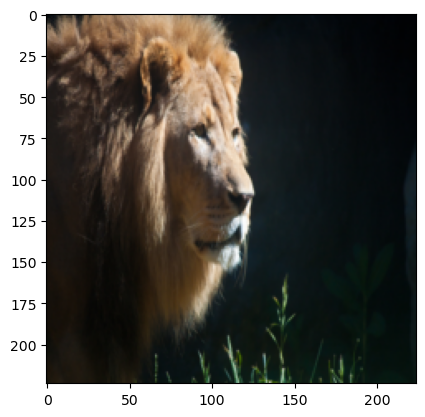

In [78]:
# 動作確認
img = Image.open(X_train_path[100])
# Resnet50では224x224が標準サイズ
transform = ImageResize(resize=224)
img_resized = transform(img, 'train')
print(img_resized.shape[0])
print(y_train[100])
#　リサイズ・データー拡張後の写真
print(img_resized.shape)
plt.imshow(img_resized.numpy().transpose((1, 2, 0)))
plt.show()

In [79]:
class Dataset(data.Dataset):

    def __init__(self, X_path, y_label, classes, transform=None, phase='train'):
        self.X_path = X_path
        self.y_label = y_label
        self.transform = transform
        self.classes = classes
        self.phase = phase
    
    def __len__(self):
        return len(self.X_path)
    
    def __getitem__(self, idx):
        # 画像を読み込み
        img_path = self.X_path[idx]
        img = Image.open(img_path)
        img_resized = self.transform(img, self.phase)
        
        # 画像ラベル
        label = self.y_label[idx]
        
        # ラベル名を数値に変換
        label_number = self.classes.index(label)
        
        return img_resized, label_number


In [80]:
#classes = ['Hippopotamus', 'Sparrow', 'Magpie', 'Rhinoceros', 'Seahorse', 'Butterfly', 'Ladybug', 'Raccoon', 'Crab', 'Pig', 'Bull', 'Snail', 'Lynx', 'Turtle', 'Canary', 'Moths and butterflies', 'Fox', 'Cattle', 'Turkey', 'Scorpion', 'Goldfish', 'Giraffe', 'Bear', 'Penguin', 'Squid', 'Zebra', 'Brown bear', 'Leopard', 'Sheep', 'Hamster', 'Panda', 'Duck', 'Camel', 'Owl', 'Tiger', 'Whale', 'Crocodile', 'Eagle', 'Otter', 'Starfish', 'Goat', 'Jellyfish', 'Mule', 'Red panda', 'Raven', 'Mouse', 'Centipede', 'Lizard', 'Cheetah', 'Woodpecker', 'Sea lion', 'Shrimp', 'Polar bear', 'Parrot', 'Kangaroo', 'Worm', 'Caterpillar', 'Spider', 'Chicken', 'Monkey', 'Rabbit', 'Koala', 'Jaguar', 'Swan', 'Frog', 'Hedgehog', 'Sea turtle', 'Horse', 'Ostrich', 'Harbor seal', 'Fish', 'Squirrel', 'Deer', 'Lion', 'Goose', 'Shark', 'Tortoise', 'Snake', 'Elephant', 'Tick']


# Datasetの作成
train_dataset = Dataset(
    X_path = X_train_path, 
    y_label = y_train,
    classes = classes,
    transform = ImageResize(resize=224),
    phase='train'
)

test_dataset = Dataset(
    X_path= X_test_path,
    y_label = y_test,
    classes=classes,
    transform = ImageResize(resize=224),
    phase='test'
)

idx = 400
print('train data shape: ', test_dataset.__getitem__(idx)[0].shape)
print('test data label : ', test_dataset.__getitem__(idx)[1])

train data shape:  torch.Size([3, 224, 224])
test data label :  13


In [81]:
batch_size = 48

train_dataloader = data.DataLoader(
    train_dataset, 
    batch_size=batch_size, 
    shuffle=True)

test_dataloader = data.DataLoader(
    test_dataset,
    batch_size= batch_size,
    shuffle=False)

example_dataloader = data.DataLoader(
    test_dataset,
    batch_size= 1,
    shuffle=True)

dataloaders_dict = {
    'train': train_dataloader, 
    'test': test_dataloader
}


In [82]:
# データローダーでデータセットの確認
batch_iterator = iter(dataloaders_dict['train'])
inputs, labels = next(batch_iterator)

print(inputs.size())
print(labels)

torch.Size([48, 3, 224, 224])
tensor([18,  6, 18,  7, 18, 17,  2,  7, 10, 10,  7,  7,  1,  2,  7,  4, 18, 14,
         7, 17,  7, 13,  9,  7,  7,  7,  7,  7, 13, 10,  7, 14, 15, 13, 10,  7,
         7, 17, 17,  5,  7,  7, 15, 18,  3, 10, 12, 14])


# Resnet50

In [62]:
# Resnet50を分類モデルに使用する

resnet50 = models.resnet50(pretrained=True)
print(resnet50)

/Users/sawaki/opt/anaconda3/envs/murata_lab/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/sawaki/opt/anaconda3/envs/murata_lab/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [66]:
# モデル全体の学習は大変なので、最終層のみファインチューニングする

# すべてのパラメータを学習しないように設定
for param in resnet50.parameters():
    param.requires_grad = False

# 最終層のパラメータのみを学習するように設定
num_features = resnet50.fc.in_features
num_classes = len(classes)   # モデルの最終出力層を19クラスに変更する
resnet50.fc = torch.nn.Linear(num_features, num_classes)
for param in resnet50.fc.parameters():
    param.requires_grad = True


print(resnet50.fc)

Linear(in_features=2048, out_features=19, bias=True)


In [67]:
#学習するパラメータの確認

def print_params(resnet50):
    print("学習しないパラメータ:")
    for name, param in resnet50.named_parameters():
        if not param.requires_grad:
            print(name)

    print("\n学習されるパラメータ:")
    for name, param in resnet50.named_parameters():
        if param.requires_grad:
            print(name)

print_params(resnet50)

学習しないパラメータ:
conv1.weight
bn1.weight
bn1.bias
layer1.0.conv1.weight
layer1.0.bn1.weight
layer1.0.bn1.bias
layer1.0.conv2.weight
layer1.0.bn2.weight
layer1.0.bn2.bias
layer1.0.conv3.weight
layer1.0.bn3.weight
layer1.0.bn3.bias
layer1.0.downsample.0.weight
layer1.0.downsample.1.weight
layer1.0.downsample.1.bias
layer1.1.conv1.weight
layer1.1.bn1.weight
layer1.1.bn1.bias
layer1.1.conv2.weight
layer1.1.bn2.weight
layer1.1.bn2.bias
layer1.1.conv3.weight
layer1.1.bn3.weight
layer1.1.bn3.bias
layer1.2.conv1.weight
layer1.2.bn1.weight
layer1.2.bn1.bias
layer1.2.conv2.weight
layer1.2.bn2.weight
layer1.2.bn2.bias
layer1.2.conv3.weight
layer1.2.bn3.weight
layer1.2.bn3.bias
layer2.0.conv1.weight
layer2.0.bn1.weight
layer2.0.bn1.bias
layer2.0.conv2.weight
layer2.0.bn2.weight
layer2.0.bn2.bias
layer2.0.conv3.weight
layer2.0.bn3.weight
layer2.0.bn3.bias
layer2.0.downsample.0.weight
layer2.0.downsample.1.weight
layer2.0.downsample.1.bias
layer2.1.conv1.weight
layer2.1.bn1.weight
layer2.1.bn1.bias
layer

In [65]:
# 画像の多値分類問題なので、損失はクロスエントロピーとする
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet50.fc.parameters(), lr=0.01)

In [67]:
# エポック数（学習に時間がかかるため、少ないが今回は5回で打ち止め）
num_epochs = 5

#device = torch.device("mps")
#model.to(device)


for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch + 1, num_epochs))
    print('-------------')
    
    for phase in ['train', 'test']:
        if phase == 'train':
            resnet50.train()
        else:
            resnet50.eval()
            
        # epochごとの累計損失
        epoch_loss = 0.0
        # epochごとの正解数
        epoch_corrects = 0
        
        for inputs, labels in dataloaders_dict[phase]:
            optimizer.zero_grad()
            
            with torch.set_grad_enabled(phase == 'train'):
                
                #推論
                outputs = resnet50(inputs)
                _, preds = torch.max(outputs, 1)
        

                loss = criterion(outputs, labels)

                # バックプロパゲーション
                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                    
                # バッチ（平均）損失*バッチサイズ
                epoch_loss += loss.item() * inputs.size(0)
                
                # 正解数
                epoch_corrects += torch.sum(preds == labels.data)

        # 損失と正答率
        epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
        epoch_acc = epoch_corrects.double() / len(dataloaders_dict[phase].dataset)

        print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

Epoch 1/5
-------------
train Loss: 1.9436 Acc: 0.7184
test Loss: 1.1775 Acc: 0.7627
Epoch 2/5
-------------
train Loss: 0.4245 Acc: 0.8972
test Loss: 1.3188 Acc: 0.8191
Epoch 3/5
-------------
train Loss: 0.3092 Acc: 0.9252
test Loss: 1.0443 Acc: 0.8321
Epoch 4/5
-------------
train Loss: 0.2922 Acc: 0.9220
test Loss: 1.1437 Acc: 0.8350
Epoch 5/5
-------------
train Loss: 0.2739 Acc: 0.9266
test Loss: 0.8242 Acc: 0.8567


In [86]:
# モデルのセーブ
#torch.save(resnet50, 'resnet50_weight.pth')


In [85]:
# modelのロード
resnet50 = torch.load('model_weight.pth')

# VGG16

In [71]:
vgg16 = torchvision.models.vgg16(pretrained = True)
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [72]:
# モデルの最終出力層を19クラスに変更する
num_features = vgg16.classifier[6].in_features
vgg16.classifier[6] = torch.nn.Linear(num_features, 19)
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [74]:
# 最終層のみファインチューニング

# 転移学習で学習させるパラメータ
params_to_update = []
 
# 最終出力層の重みとバイアス
update_param_names = ['classifier.6.weight', 'classifier.6.bias']
 
# 出力層以外は勾配計算をなくし、変化しないように設定
for name, param in vgg16.named_parameters():
    if name in update_param_names:
        param.requires_grad = True # 勾配計算オン
        params_to_update.append(param) 
    else:
        param.requires_grad = False


print_params(vgg16)

学習しないパラメータ:
features.0.weight
features.0.bias
features.2.weight
features.2.bias
features.5.weight
features.5.bias
features.7.weight
features.7.bias
features.10.weight
features.10.bias
features.12.weight
features.12.bias
features.14.weight
features.14.bias
features.17.weight
features.17.bias
features.19.weight
features.19.bias
features.21.weight
features.21.bias
features.24.weight
features.24.bias
features.26.weight
features.26.bias
features.28.weight
features.28.bias
classifier.0.weight
classifier.0.bias
classifier.3.weight
classifier.3.bias

学習されるパラメータ:
classifier.6.weight
classifier.6.bias


In [75]:
# 画像の多値分類問題なので、損失はクロスエントロピーとする
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(params=params_to_update, lr=0.01)

In [83]:
# エポック数（学習に時間がかかるため、少ないが今回は5回で打ち止め）
num_epochs = 5


for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch + 1, num_epochs))
    print('-------------')
    
    for phase in ['train', 'test']:
        if phase == 'train':
            vgg16.train()
        else:
            vgg16.eval()
            
        # epochごとの累計損失
        epoch_loss = 0.0
        # epochごとの正解数
        epoch_corrects = 0
        
        for inputs, labels in dataloaders_dict[phase]:
            optimizer.zero_grad()
            
            with torch.set_grad_enabled(phase == 'train'):
                
                #推論
                outputs = vgg16(inputs)
                _, preds = torch.max(outputs, 1)
        

                loss = criterion(outputs, labels)

                # バックプロパゲーション
                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                    
                # バッチ（平均）損失*バッチサイズ
                epoch_loss += loss.item() * inputs.size(0)
                
                # 正解数
                epoch_corrects += torch.sum(preds == labels.data)

        # 損失と正答率
        epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
        epoch_acc = epoch_corrects.double() / len(dataloaders_dict[phase].dataset)

        print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

Epoch 1/5
-------------
train Loss: 2.2002 Acc: 0.7005
test Loss: 1.6420 Acc: 0.7496
Epoch 2/5
-------------
train Loss: 1.0761 Acc: 0.8231
test Loss: 1.9151 Acc: 0.7381
Epoch 3/5
-------------
train Loss: 1.1315 Acc: 0.8263
test Loss: 2.9531 Acc: 0.7641
Epoch 4/5
-------------
train Loss: 1.0503 Acc: 0.8493
test Loss: 2.2668 Acc: 0.7699
Epoch 5/5
-------------
train Loss: 0.9542 Acc: 0.8587
test Loss: 2.5595 Acc: 0.7916


In [84]:
# モデルのセーブ
#torch.save(vgg16, 'vgg16_weight.pth')

In [87]:
# modelのロード
vgg16 = torch.load('vgg16_weight.pth')

# 結果の分析

In [108]:
# 分類詳細確認のための関数

pd.options.display.float_format = "{:.3f}".format

def classification_check(model, idx):
    
    if model == resnet50: modelname = 'resnet50'
    if model == vgg16: modelname = 'vgg16'

    print('--- model : {} ---'.format(modelname))

    img = Image.open(X_test_path[idx])
    print('正解ラベル:', y_test[idx])

    transform = ImageResize(resize=224)
    img_resized = transform(img, 'train')

    plt.imshow(img_resized.numpy().transpose((1, 2, 0)))
    plt.show()

    img_resized = torch.tensor(img_resized)
    img_resized = torch.reshape(img_resized, (1,3,224,224))


    # ラベルを予測
    outputs = model(img_resized)
    _, preds = torch.max(outputs, 1)

    pred_logit = outputs
    pred_prob = F.softmax(pred_logit, dim=1).clone().detach().numpy()

    df = pd.DataFrame(pred_prob, columns=classes).rename(index={0:'{}'.format(modelname)}).T
    # display(df)
    #print(preds)

    return df



--- model : resnet50 ---
正解ラベル: Leopard


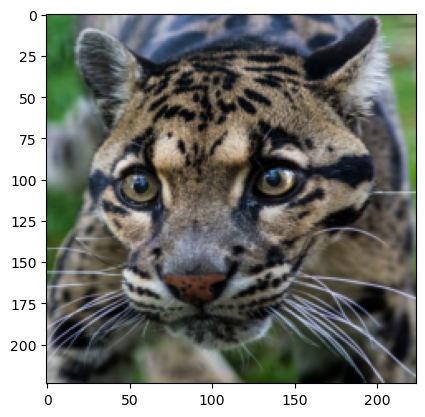

/var/folders/v6/0z_kylj93ll5z4_htn4grf000000gn/T/ipykernel_5649/4243875343.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img_resized = torch.tensor(img_resized)


--- model : vgg16 ---
正解ラベル: Leopard


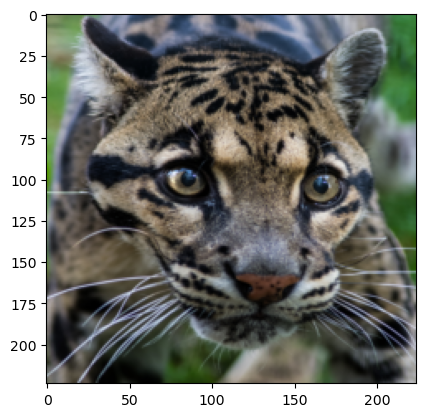

/var/folders/v6/0z_kylj93ll5z4_htn4grf000000gn/T/ipykernel_5649/4243875343.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img_resized = torch.tensor(img_resized)


,Zebra,Lion,Leopard,Cheetah,Tiger,Bear,Brown Bear,Butterfly,Canary,Crocodile,Polar Bear,Bull,Camel,Crab,Chicken,Centipede,Cattle,Caterpillar,Duck
resnet50,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
vgg16,0.000,0.000,0.771,0.000,0.229,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


In [129]:
idx = 75
df_resnet = classification_check(resnet50, idx)
df_vgg =classification_check(vgg16, idx)

df_concat = pd.concat([df_resnet, df_vgg], axis=1)
display(df_concat.T)